<a href="https://colab.research.google.com/github/piyushgoel997/MutationClassification/blob/master/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import statements and declaring some global variables


In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.utils import plot_model
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score
from sklearn.utils import shuffle
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Conv1D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

data_url = "https://raw.githubusercontent.com/piyushgoel997/MutationClassification/master/data.csv"
epochs = 200
batch_size = 8192

# to stop the model from overfitting on the training data.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20, verbose=2, mode="min", restore_best_weights=True)

Using TensorFlow backend.


Load and represent data in a one-hot encoded matrix form to be easily able to train the model.

Matrix Dimentions: Number of examples, Number of Features (in this case, the length of the sequence of Amino Acids), Number of possible feature values (20 possible Amino Acids)

In [2]:
def get_aa_encoder():
    """
    One-hot encoding indices for the 20 possible amino acids.
    :return: the dictionary mapping amino acid to index in the one-hot encoding.
    """
    acids = "ARNDCEQGHILKMFPSTWYV"
    indices = {}
    i = 0
    for a in acids:
        indices[a] = i
        i += 1
    return indices


def make_matrix(seq, alt):
    """
    makes a matrix where each of the 51 features correspond to the amino acid at
    that position in the sequence after the one-hot encoding using the indices
    provided. Also puts a -1 at in the middle most feature at the position
    corresponding to the alt amino acid.
    :param seq: the sequence to be encoded.
    :param alt: the alternate amino acid
    :return: the resultant encoded matrix (51 X 20)
    """
    indices = get_aa_encoder()
    matrix = np.zeros((len(indices), len(seq)))
    i = 0
    for s in seq:
        matrix[indices[s]][i] = 1
        i += 1
    matrix[indices[alt]][int(len(seq) / 2)] = -1
    return matrix.T


def map_description(description):
    map = {'Benign': 0, 'Benign/Likely benign': 0, 'Likely benign': 0,
           'Likely pathogenic': 1, 'Pathogenic': 1, 'Pathogenic/Likely pathogenic': 1}
    return map[description]


X = []
Y = []
gene_ids = []
mutations = pd.read_csv(data_url)

for _, row in mutations.iterrows():
    X.append(make_matrix(row["REF_SEQ"], row["ALT_AA"]))
    Y.append(map_description(row["DESCRIPTION"]))
    gene_ids.append(row["UNIPROT_ACCESSION"])

X = np.array(X)
Y = np.array(Y)

X, Y = shuffle(X, Y)

print("Input shape", X.shape, "\nOutput shape", Y.shape)
print("Count of Pathogenic examples", np.count_nonzero(Y == 1))
print("Count of Benign examples", np.count_nonzero(Y == 0))

Input shape (229502, 51, 20) 
Output shape (229502,)
Count of Pathogenic examples 41045
Count of Benign examples 188457


Helper methods to be initialize and comple the model, and do the k-fold cross validation and provide different evaluation metrics like accuracy, loss, ROC curve, ROC AUC, PRC curve.

In [0]:
def get_model(h=0):
    """
    make, compile and return the model
    :param h: The number of hidden layers with 64 channels to be added
    :return: the model
    """
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation="relu"))
    for _ in range(h):
        model.add(Conv1D(64, kernel_size=5, activation="relu"))
        model.add(BatchNormalization())
    model.add(Conv1D(32, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(1, kernel_size=1, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling1D())
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model


def get_model2(h):
    """
    make, compile and return the model. Incresed the kernel size.
    :param h: The number of hidden layers with 64 channels to be added
    :return: the model
    """
    model = Sequential()
    model.add(Conv1D(32, kernel_size=5, activation="relu"))
    for _ in range(h):
        model.add(Conv1D(64, kernel_size=7, activation="relu"))
        model.add(BatchNormalization())
    model.add(Conv1D(32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(1, kernel_size=1, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling1D())
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model


def k_fold_cross_validation(h, X, Y, k=10, epochs=20, batch_size=512, callbacks=None, get_model=get_model):
    """
    Make the model, train it, and validate it using k-fold cross validation.
    :param h: The number of hidden layers with 64 channels to be added in the model.
    :param X: input to the model.
    :param Y: expected outputs of the model.
    :return: average accuracy, avg auc, k roc curve coordinates, k prc curve coordinates.
    """
    avg_accuracy_tain = 0
    avg_accuracy_val = 0
    avg_loss_train = 0
    avg_loss_val = 0
    avg_roc_auc = 0
    roc_curves = []
    prc_curves = []
    summary = []
    results = ""
    for i in range(k):
        model = get_model(h)
        print("========Cross Validation:", str(i + 1) + "/" + str(k) + "========")
        start = int(X.shape[0] * (i / k))
        end = int(X.shape[0] * ((i + 1) / k))
        test_data = X[start:end]
        y_test = Y[start:end]
        train_data = np.concatenate([X[:start], X[end:]])
        y_train = np.concatenate([Y[:start], Y[end:]])
        history = model.fit(train_data, y_train, validation_data=(test_data, y_test), callbacks=callbacks, batch_size=batch_size, epochs=epochs, verbose=2)
        test_out = model.predict(test_data)
        if results == "":
            results = test_out
        else:
            results = np.concatenate(results, test_out)
        fpr, tpr, _ = roc_curve(y_test, test_out)
        roc_curves.append((fpr, tpr))
        avg_roc_auc += auc(fpr, tpr)
        p, r, _ = precision_recall_curve(y_test, test_out)
        prc_curves.append((r, p))
        avg_accuracy_tain += history.history['accuracy'][-1]
        avg_accuracy_val += history.history['val_accuracy'][-1]
        avg_loss_train += history.history['loss'][-1]
        avg_loss_val += history.history['val_loss'][-1]
        
        if len(summary) == 0: model.summary(print_fn=lambda x: summary.append(x))

        del model

    return {"avg_accuracy_train": avg_accuracy_tain / k, "avg_accuracy_val": avg_accuracy_val / k,
            "avg_loss_train": avg_loss_train / k, "avg_loss_val": avg_loss_val / k,
            "avg_roc_auc": avg_roc_auc / k, "roc": roc_curves, "prc": prc_curves,
            "model_summary": "\n".join(summary), "predictions": results}


def genes_with_both(gene_ids, Y, pred):
    """
    Gets the accuracy of the predictions on genes containing both pathogenic and benign mutations.
    Also the number of genes conatining both, and the number of examples belonging to those genes.
    """
    patho = set()
    benign = set()
    for i in range(len(gene_ids)):
        if Y[i] == 1:
            patho.add(gene_ids[i])
        else:
            benign.add(gene_ids[i])
    intersec = patho.intersection(benign)
    y_true = []
    y_pred = []
    for y, y_, id in zip(Y, pred, gene_ids):
        if id in intersec:
            y_true.append(y)
            y_pred.append(y_)
    return {"Accuracy": accuracy_score(y_true, y_pred), "total": len(y_true), "genes_with_both": len(intersec)}

Training and evaluating a few different models (with different number of hidden layers) and chosing the best one.

In [5]:
# best_h_acc = -1  # best h value when chosen based on the validation accuracy.
# best_acc = 0
best_h_auc = -1  # best h value when chosen based on the validation auc value.
best_auc = 0
best_pred = ""

over_all_start_time = time.time()

for h in [1, 2, 4]:
  for model_maker in [get_model, get_model2]:
    start_time = time.time()
    print("==========Starting for h =", str(h) + "==========")

    metrics = k_fold_cross_validation(h, X, Y, k=5, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping_callback], get_model=model_maker)

    print(metrics["model_summary"])

    print("Final metrics for this model")
    print("Average of the final training set accuracy over all folds =", str(metrics["avg_accuracy_train"]))
    print("Average of the final training set loss over all folds =", str(metrics["avg_loss_train"]))
    print("Average of the final validation set accuracy over all folds =", str(metrics["avg_accuracy_val"]))
    print("Average of the final validation set loss over all folds =", str(metrics["avg_loss_val"]))
    print("Average of the ROC AUC over all folds =", str(metrics["avg_roc_auc"]))
    pred = metrics["predictions"]

    # TODO get gene_ids in the variable
    print("Genes with both pathogenic and benign mutations:")
    print(genes_with_both(gene_ids, Y, pred))

    for c in metrics["roc"]: plt.plot(*c)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.show()

    for c in metrics["prc"]: plt.plot(*c)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PRC curve')
    plt.show()

    # if metrics["avg_accuracy_val"] > best_acc:
    #     best_h_acc = h
    #     best_acc = metrics["avg_accuracy_val"]

    if metrics["avg_roc_auc"] > best_auc:
        best_h_auc = h
        best_auc = metrics["avg_roc_auc"]
        best_pred = pred

    print("Time taken for this model", str(time.time() - start_time))

    print("===============Finished===============")

print("Total time taken", str(time.time() - over_all_start_time))
print("The h value for the best validation accuracy is", str(best_h_acc), "and the corresponding accuracy is",
      str(best_acc))
print("The h value for the best auc is", str(best_h_auc), "and the corresponding auc is", str(best_auc))

==========Starting for h = 1==========
========Cross Validation: 1/5========
Epoch 1/200
23/23 - 2s - loss: 1.1207 - accuracy: 0.1793 - val_loss: 0.2655 - val_accuracy: 0.1769
Epoch 2/200
23/23 - 1s - loss: 0.4682 - accuracy: 0.1793 - val_loss: 0.2794 - val_accuracy: 0.1769
Epoch 3/200
23/23 - 1s - loss: 0.3285 - accuracy: 0.1796 - val_loss: 0.2782 - val_accuracy: 0.1769
Epoch 4/200
23/23 - 1s - loss: 0.2465 - accuracy: 0.5431 - val_loss: 0.2567 - val_accuracy: 0.1769
Epoch 5/200
23/23 - 1s - loss: 0.1933 - accuracy: 0.8234 - val_loss: 0.2320 - val_accuracy: 0.8231
Epoch 6/200
23/23 - 1s - loss: 0.1617 - accuracy: 0.8250 - val_loss: 0.2094 - val_accuracy: 0.8231
Epoch 7/200
23/23 - 1s - loss: 0.1461 - accuracy: 0.8268 - val_loss: 0.1923 - val_accuracy: 0.8231
Epoch 8/200
23/23 - 1s - loss: 0.1386 - accuracy: 0.8340 - val_loss: 0.1802 - val_accuracy: 0.8231
Epoch 9/200
23/23 - 1s - loss: 0.1340 - accuracy: 0.8365 - val_loss: 0.1706 - val_accuracy: 0.8231
Epoch 10/200
23/23 - 1s - loss: 

KeyboardInterrupt: ignored

Now training the best model architecture using the whole data

Epoch 1/100
29/29 [==============================] - 3s 89ms/step - loss: 0.7703 - accuracy: 0.1797
Epoch 2/100
29/29 [==============================] - 2s 84ms/step - loss: 0.3014 - accuracy: 0.2327
Epoch 3/100
29/29 [==============================] - 2s 84ms/step - loss: 0.2099 - accuracy: 0.8036
Epoch 4/100
29/29 [==============================] - 2s 83ms/step - loss: 0.1691 - accuracy: 0.8278
Epoch 5/100
29/29 [==============================] - 2s 85ms/step - loss: 0.1505 - accuracy: 0.8301
Epoch 6/100
29/29 [==============================] - 2s 85ms/step - loss: 0.1416 - accuracy: 0.8344
Epoch 7/100
29/29 [==============================] - 2s 85ms/step - loss: 0.1392 - accuracy: 0.8369
Epoch 8/100
29/29 [==============================] - 2s 83ms/step - loss: 0.1346 - accuracy: 0.8394
Epoch 9/100
29/29 [==============================] - 2s 83ms/step - loss: 0.1305 - accuracy: 0.8424
Epoch 10/100
29/29 [==============================] - 2s 83ms/step - loss: 0.1252 - accuracy: 0.8465

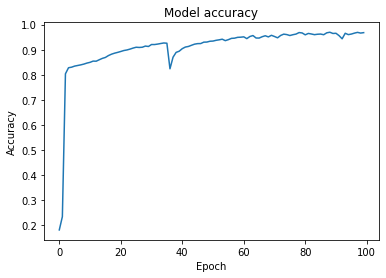

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_80 (Conv1D)           multiple                  1952      
_________________________________________________________________
conv1d_81 (Conv1D)           multiple                  10304     
_________________________________________________________________
batch_normalization_65 (Batc multiple                  256       
_________________________________________________________________
conv1d_82 (Conv1D)           multiple                  20544     
_________________________________________________________________
batch_normalization_66 (Batc multiple                  256       
_________________________________________________________________
conv1d_83 (Conv1D)           multiple                  20544     
_________________________________________________________________
batch_normalization_67 (Batc multiple                

In [0]:
best_h = best_h_auc

model = get_model(best_h)
history = model.fit(X, Y, batch_size=batch_size, epochs=epochs)

plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plot_model(model, to_file='model.png')
model.summary()
model.save("model.h5")

Trying out models with wider hidden layers.